# COSC 4610/5610 Project 1 (Spring 2024)

**Team members**: Taylor Czerwinski, taylor.czerwinski@marquette.edu

**Submission.** Please insert your names and emails above, save your code in this notebook, and explain what you are doing along with your findings in text cells. You can think of it as a technical report with code. Before submission, please use `Kernel -> Restart & Run All` in the Jupyter menu to verify your code is runnable and save all outputs. Afterwards, you can upload your raw notebook(s).  


In this project, we will practice with data cleaning and transformation methods on the California house sales data and check their effects on the price prediction model. The model training and the evaluation code will be given. Your job is to try different data pre-processing methods to obtain the best root mean squared logarithmic error (RMSLE) on the test dataset.


## necessary packages on Linux/Mac
Install the necessary packages: `pip3 install notebook numpy pandas matplotlib scikit-learn lightgbm`

## Sample Steps of Exploratory Data Analysis 

Download the data from http://www.cs.mu.edu/~keke/dm/data/house_sales.ftr. Note that we use the [`feather` format](https://arrow.apache.org/docs/python/feather.html). 
 

In [1]:
# inline package installation, if you haven't done outside
#!pip3 install notebook numpy pandas matplotlib scikit-learn lightgbm --upgrade  


In [2]:
# If the pacakges are not installed, run the following line once to install. You may need to restart your runtime afterwards:
#!pip3 install numpy pandas scikit-learn lightgbm --upgrade  
import pandas as pd
import numpy as np

data = pd.read_feather('house_sales.ftr')
data.shape

(164944, 1789)

We select a few columns to demonstrate. You need to select more columns to make your model more accurate. 

In [3]:
# select a small number columns for demonstrating how to clean data and train models
columns = ['Sold Price', 'Sold On', 'Type', 'Year built', 'Bedrooms']


df0 = data[columns].copy()
# uncomment the below line to save memory
# del data
df0.dtypes

Sold Price    object
Sold On       object
Type          object
Year built    object
Bedrooms      object
dtype: object

Data type "object" is the initial type when data is loaded in. We want to convert each to numeric and remove missing values and errors.

1. We convert `Sold Price` to numerical values, which is our prediction target. We also remove examples whose prices are too high or too low. For more data cleaning/transformation examples, you can revisit the notebook https://www.cs.mu.edu/~keke/dm/data/house.ipynb.

In [4]:

c = 'Sold Price'
    
df0[c] = np.log10(df0[c].replace(
        r'[$,-]', '', regex=True).replace(
        r'^\s*$', np.nan, regex=True).astype(float))

# you can reuse this code for parsing any dollar related columns
#(some column of a data frame).replace(r'[$,-]', '', regex=True).replace(r'^\s*$', np.nan, regex=True).astype(float)

df1 = df0[(df0['Sold Price'] >= 4 ) & (df0['Sold Price'] <= 8 )] # use the prices between 10^4 and 10^8 only
df1.dtypes

Sold Price    float64
Sold On        object
Type           object
Year built     object
Bedrooms       object
dtype: object

In [5]:
df1.shape

(160838, 5)

2. Now handle "Type"

In [6]:
df1['Type'].value_counts()

Type
SingleFamily                                              100040
Condo                                                      26666
MultiFamily                                                 7189
Townhouse                                                   6818
Unknown                                                     5817
                                                           ...  
1 Level, Low-Rise (1-3), Unit Above, Ground Floor              1
Detached, 3 Story, Full                                        1
1 Level, Luxury, New Construction, Mid-Rise (4-8)              1
1 Level, Luxury, Low-Rise (1-3), End Unit                      1
Unit Below, Low-Rise (1-3), Full, Unit Above, Attached         1
Name: count, Length: 317, dtype: int64

Let's only use the first four types of houses, which considered very rough -- ignore many other types (the predictor will not work on the skipped types)

In [7]:
df1 = df1[df1['Type'].isin(['SingleFamily', 'Condo', 'MultiFamily', 'Townhouse'])]
df1['Type'].value_counts()

Type
SingleFamily    100040
Condo            26666
MultiFamily       7189
Townhouse         6818
Name: count, dtype: int64

In [8]:
# convert to categorical and then conver to integers
df1['Type'] = df1['Type'].astype('category').cat.codes
df1['Type'].value_counts()

Type
2    100040
0     26666
1      7189
3      6818
Name: count, dtype: int64

In [9]:
# 3. handle "Year built"
df1['Year built'].value_counts()

Year built
No Data    5821
1973       2212
2018       2161
1950       2096
2006       1959
           ... 
1650          1
1862          1
19            1
1571          1
1471          1
Name: count, Length: 180, dtype: int64

In [10]:
#remove "No Data" -- do any missing-value imputation methods work here?
df1 = df1[df1['Year built'] != 'No Data']
df1['Year built'] = df1['Year built'].astype('int')
# get rid of too old or irregular value 
df1 = df1[(df1['Year built']>1900)  & (df1['Year built'] < 2023)]
df1['Year built'].value_counts()

Year built
1973    2212
2018    2161
1950    2096
2006    1959
1955    1956
        ... 
1917     184
1903     168
1901     141
1902     140
2021      98
Name: count, Length: 121, dtype: int64

In [11]:
df1.shape # check how many records are left so far

(132348, 5)

In [12]:
#4. handle "Bedrooms", find the most frequent values first
df1['Bedrooms'].value_counts()

Bedrooms
3                                                                                                                                                                    45514
2                                                                                                                                                                    28586
4                                                                                                                                                                    23194
1                                                                                                                                                                     6966
5                                                                                                                                                                     6801
                                                                                                                                        

In [13]:
# we see a lot of noises; let's keep only the reasonable ones[0, 10] bedrooms
df1  = df1[df1['Bedrooms'].isin([str(i) for i in range(11)])]
df1['Bedrooms'] = df1['Bedrooms'].astype('int')
df1['Bedrooms'].value_counts()

Bedrooms
3     45514
2     28586
4     23194
1      6966
5      6801
6      1723
0      1200
7       469
8       367
10      144
9       127
Name: count, dtype: int64

In [14]:
df1.shape # the number examples left so far

(115091, 5)

We use the house sales between 2021-2-15 and 2021-3-1 as our test data. You can use any example before 2021-2-15 for training, but not after, as a prediction model can only be built with historical data and tested on more recent data. In other words, we pretend we are launching our model on 2021-2-15 and testing it for 2 weeks. Here we only use sales in 2021 for fast training. You should extend the selection range to include more data in your experiments  

In [15]:

# split_data function can be used later before run modeling
def split_data(df, train_timestamp):
    # you can change the train_timestamp to include more training. It cannot be newer than pd.Timestamp(2021, 2, 15)
    # test data period is fixed.
    test_start, test_end = pd.Timestamp(2021, 2, 15), pd.Timestamp(2021, 3, 1)
    train_start = train_timestamp  
    df['Sold On'] = pd.to_datetime(df['Sold On'], errors='coerce')
    train = df[(df['Sold On'] >= train_start) & (df['Sold On'] < test_start)]
    test = df[(df['Sold On'] >= test_start) & (df['Sold On'] < test_end)]
    return train, test

# the following sample code include only 2021 data for training 
#train, test = split_data(df1, pd.Timestamp(2021, 1, 1))
#train.shape, test.shape

In [16]:

# get feature vectors and target values for train and test data, respectively. The target attribute is always "Sold Price"
# If you want to include more features, include them in the beginning and perform appropriate preprocessing.
# you can call the function prepare_train_test in your code

def prepare_train_test(train, test, features):
    target = "Sold Price"
    X_train = train.loc[:, features ]
    y_train = train.loc[:, [target]]
    X_test = test.loc[:, features]
    y_test = test.loc[:, [target]]
    return X_train, y_train, X_test, y_test

# for the demo program, we use only three features so far
#features = ["Type", "Year built", 'Bedrooms'] 
# we include all the features we selected for preprocessing earlier, except for "Sold On", which is not a good feature for predicting future sales, apparently
#X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)


## Regression Baseline

We compute the baseline model with a gradient boosting regressor (GBM), which is a non-linear regression method. The specific implementation is called LightGBM. Details of modeling methods will be covered in later lectures. Thus, now we recommend that you reuse the following "modeling" function so that you can focus on data preprocessing. 

We use the root mean squared error (RMSE) to represent the prediction quality. With the few features, the baseline RMSE is around 0.26. We want to smaller RMSE as possible.

In [17]:
# if the packages are not installed, install them using 
# pip install sklearn lightgbm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

# define modeling function can be used later
def modeling (x_train, y_train, x_test, y_test):
    # training and test data as input
    print('Starting training...')
    # train
    gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=100)
    gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(5)])

    print('Starting predicting...')
    # predict
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
    # eval
    # use root mean squared error (RMSE)
    rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
    print(f'The RMSE of prediction is: {rmse_test}')
    return gbm


In [18]:

# you will use this piece of code for testing the cleaned data you get so far
# get the training and testing split
train, test = split_data(df1, pd.Timestamp(2021, 1, 1))

# need to specify the selected features
features = ["Type", "Year built", 'Bedrooms'] 
X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)
# run modeling
predictor = modeling(X_train, y_train, X_test, y_test)
X_train.shape


/var/folders/xy/0gk1fqsd08170php7y3xrqb80000gn/T/ipykernel_41326/1318690691.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Sold On'] = pd.to_datetime(df['Sold On'], errors='coerce')


Starting training...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 20031, number of used features: 3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 5.795896
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 0.0672473
Starting predicting...
The RMSE of prediction is: 0.25932083531104194


(20031, 3)

Next, we compute the importance of each feature, along with several other metrics. 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

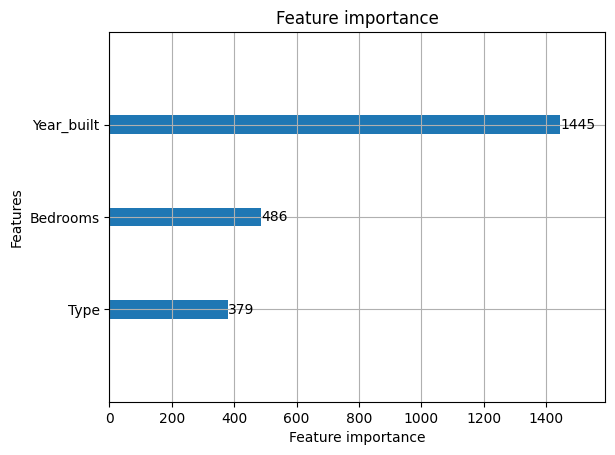

In [19]:
lgb.plot_importance(predictor)

###### Your Tasks

Your goal is to train a model using the features in the original dataset that minimizes the RMSE on the validation dataset. While the naïve model achieves an RMSE of ~0.26, it is possible to achieve an error of less than 0.08 on the same dataset.  

Complete the following tasks after you walk through the above modeling steps. 

1. Read good practices in organizing your Jupyter code https://ploomber.io/blog/clean-nbs/. Move the existing functions out to a .py file (i.e., a module), import them, and test your code. 
   
2. Check more data cleaning and transformation examples in https://www.cs.mu.edu/~keke/dm/data/house.ipynb. You want to clean the null value columns first and then work on the remaining columns (about 30 columns left).
```
    null_sum = data.isnull().sum()
    data.drop(columns=data.columns[null_sum > len(data) * 0.3], inplace=True) 
```
  (2.1) Include more numeric attributes that might be relevant to the sold price, e.g.,  dollar-related ones such as 'Tax assessed value', 'Annual tax amount', different kinds of areas, bedrooms/bathrooms, distances, and school scores. **Do not include "Listed Price", as they may have considered z-estimate (the output of the prediction model). "Sold On" is always kept in the dataset as it is needed by the split_data function. However, it should not be used as a feature directly in modeling -- its derived features are OK, such as month or days of the year.** Reuse some code in house.ipynb and convert these attributes to float or int values correspondingly, and then test whether more attributes help improve the model quality (i.e., rerun the modeling code and check the final RMSE). 

  (2.2) Then, include one categorical attribute, "zipcode", and convert it to numeric values (check the example of converting "Type") and check the model quality again. 


    

   (2.3) Let's conduct some experiments on noise reduction and imputation. For example, for the "Type" attribute, you may have observed that "SingleFamily" has typos such as "Single Family". Replace these noisy values with the correct ones. You may find similar problems with other attributes. Describe what you do and report the model quality change. 

Note that these tasks still use the training data from 2021 (as used earlier). However, if the training or testing data size becomes too small (e.g., < 1000) due to aggressive data cleaning at a certain step, the model quality assessment is unreliable.  You want to keep an eye on the number of remaining samples at each significant step (e.g., check df.shape often). 

3. Based on the best processing steps you observed so far, experiment with more training examples. A larger number of examples in the years earlier than 2021 can also be included. Try different periods, e.g., since 2020, since 2019, etc., but always keep the house sales between 2021-2-15 and 2021-3-1 as our test data. Reuse the "split_data" function with different time_stamps to extract the samples. Also, check whether the top features (e.g., the top 3) may change for different periods. Describe what you do and report the RMSE change and top features with different periods of training data. 


4. Finally, summarize the best model you get: the features you used, data cleaning strategies, training data size, testing data size, RMSE, and the top features of the best model. 



In [20]:
# YOUR SOLUTION HERE
import pandas as pd 
import numpy as np
import seaborn as sns

data = pd.read_feather('house_sales.ftr')
data.shape

null_sum = data.isnull().sum()
data.drop(columns=data.columns[null_sum > len(data) * 0.3], inplace=True) 
columns = ['Sold Price', 'Sold On', 'Type','Year built', 'Bedrooms', 'Bathrooms', 'Total interior livable area', 'Total spaces',
           'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'High School Score', 'High School Distance',
           'Lot size', 'Tax assessed value', 'Annual tax amount', 'Zip']
data.dtypes
#data.shape

Id                             object
Address                        object
Sold Price                     object
Sold On                        object
Summary                        object
Type                           object
Year built                     object
Heating                        object
Cooling                        object
Parking                        object
Bedrooms                       object
Bathrooms                      object
Total interior livable area    object
Total spaces                   object
Garage spaces                  object
Home type                      object
Region                         object
Elementary School              object
Elementary School Score        object
Elementary School Distance     object
High School                    object
High School Score              object
High School Distance           object
Heating features               object
Parking features               object
Lot size                       object
Parcel numbe

In [21]:
#Cleaning and Converting datatypes to float or int

#Id
data["Id"] = data["Id"].astype(int)

#Sold Price
data['Sold Price'] = np.log10(data['Sold Price'].replace(
        r'[$,-]', '', regex=True).replace(
        r'^\s*$', np.nan, regex=True).astype(float))
data = data[(data['Sold Price'] >= 4 ) & (data['Sold Price'] <= 8 )]

#Type
data['Type'].replace('Single Family', 'SingleFamily')
data['Type'].replace('Multi Family', 'MultiFamily')
data['Type'].replace('Town house', 'Townhouse')

data = data[data['Type'].isin(['SingleFamily', 'Condo', 'MultiFamily', 'Townhouse'])]
data['Type'].value_counts()
data['Type'] = data['Type'].astype('category').cat.codes

#Year built
data = data[data['Year built'] != 'No Data']
data['Year built'] = data['Year built'].astype('int')
# get rid of too old or irregular value 
data = data[(data['Year built']>1900)  & (data['Year built'] < 2023)]
data['Year built'].value_counts()

#Bedrooms
data  = data[data['Bedrooms'].isin([str(i) for i in range(11)])]
data['Bedrooms'] = data['Bedrooms'].astype('int')
data['Bedrooms'].value_counts()

#Bathrooms
data['Bathrooms'] = data['Bathrooms'].astype('float')
data['Bathrooms'].value_counts()

#Total spaces
data["Total spaces"] = data["Total spaces"].astype(float)

#Garage spaces
data["Garage spaces"] = data["Garage spaces"].astype(float)

#Elementary School Score
data = data[data['Elementary School Score'] != 'None']
data['Elementary School Score'] = data['Elementary School Score'].astype('float')

#Elementary School Distance
data = data[data['Elementary School Distance'] != 'None']
data['Elementary School Distance'] = data['Elementary School Distance'].astype('float')

#High School Score
data = data[data['High School Score'] != 'None']
data['High School Score'] = data['High School Score'].astype('float')

#High School Distance
data = data[data['High School Distance'] != 'None']
data['High School Distance'] = data['High School Distance'].astype('float')

#Sold Price, Listed Price, Tax assessed value, Annual tax ammount
currency = ['Sold Price', 'Listed Price', 'Tax assessed value', 'Annual tax amount']
for c in currency:
    data[c] = data[c].replace(
        r'[$,-]', '', regex=True).replace(
        r'^\s*$', np.nan, regex=True).astype(float)

#Zip
data = data[data['Zip'].isin(data['Zip'].value_counts()[:20].keys())]
data['Zip'] = data['Zip'].astype('category').cat.codes

print(data.shape)
data[columns].dtypes

(12915, 32)


Sold Price                     float64
Sold On                         object
Type                              int8
Year built                       int64
Bedrooms                         int64
Bathrooms                      float64
Total interior livable area     object
Total spaces                   float64
Garage spaces                  float64
Elementary School Score        float64
Elementary School Distance     float64
High School Score              float64
High School Distance           float64
Lot size                        object
Tax assessed value             float64
Annual tax amount              float64
Zip                               int8
dtype: object

In [22]:
areas = ['Total interior livable area', 'Lot size']
for c in areas:
    acres = data[c].str.contains('Acres') == True
    col = data[c].replace(r'\b sqft\b|\b Acres\b|\b,\b','', regex=True).astype(float)
    col[acres] *= 43560
    data[c] = col

data[columns].head(20)
data.shape

(12915, 32)

In [23]:
abnormal = (data[areas[1]] < 10) | (data[areas[1]] > 1e4)
data = data[~abnormal]
sum(abnormal)
data[columns].shape

(9801, 17)

In [24]:
train, test = split_data(data, pd.Timestamp(1900, 1, 1))
print(train.shape)
print(test.shape)

# need to specify the selected features
features = ['Sold Price', 'Type','Year built', 'Bedrooms', 'Bathrooms', 'Total interior livable area', 'Total spaces',
           'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'High School Score', 'High School Distance',
           'Lot size', 'Tax assessed value', 'Annual tax amount', 'Zip']
X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)

# run modeling
predictor = modeling(X_train, y_train, X_test, y_test)
X_train.shape

(9654, 32)
(142, 32)
Starting training...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 9654, number of used features: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 5.979513
Training until validation scores don't improve for 5 rounds


/var/folders/xy/0gk1fqsd08170php7y3xrqb80000gn/T/ipykernel_41326/1318690691.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Sold On'] = pd.to_datetime(df['Sold On'], errors='coerce')


Early stopping, best iteration is:
[89]	valid_0's l2: 2.78623e-05
Starting predicting...
The RMSE of prediction is: 0.0052784842414850385


(9654, 16)

The best RSME of prediction I achieved was 0.0053. I used 16 different features to achieve this: 'Sold Price', 'Type','Year built', 'Bedrooms', 'Bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'High School Score', 'High School Distance', 'Lot size', 'Tax assessed value', 'Annual tax amount', 'Zip'. To achieve this low of an RMSE score, I split the data starting at 1/1/2018. I found that any later than 1/1/2018, the RSME increases. A date of as early as 1/1/1850, also maintains an RSME score of 0.0053. This is due to the model having more data to train on. Within the split_data function, the test data was from 2021-2-15 and 2021-3-1. As I changed 2021-2-15 to an earlier date, such as 2020-1-12, the RSME increased to 0.158. This is due to a larger amount of test data and a smaller training data set. The model was not trained as much, hence it is not as accurate. 

To clean the data, for most of the columns, I removed null values (or String values used to represent null: None, No Data, etc.). For Type and Zip, I converted the categorical data to numerical using cat.codes. For Sold Price, Listed Price, Tax assessed value, Annual tax amount, I had to remove $, ,, ^, etc before I could convert those columns to numerical data. For Total interior livable area and Lot size, if in Acres, I converted to sqft and removed any textual data before converting it to float/int. I converted 16 columns to numerical values. 

The training data consisted of 9654 records and the training data consisted of 142 records. As I increase the size of the testing data set, the accuracy of the model decreases. (For example, with 8784 records for training the model and 1012 records for testing the model, the RMSE of prediction is 0.016.